In [ ]:
import cv2
import numpy as np

# Global variables

src = None
src_gray = None
dst = None
detected_edges = None
Blur = None

contours = []
hierarchy = []

# to do: these variables should be parameterized based on image quality (pixel density) and input image size
edgeThresh = 1
lowThreshold = 100
max_lowThreshold = 200
ratio = 3
kernel_size = 3
convexityMinPixelDepth = 8

window_name = "Edge Map"
window_blur = "blur map"

def FindingAngle(minRect):
    if minRect.size.width < minRect.size.height:
        print(f"oggetto ruotato di: {minRect.angle+180:.2f} gradi rispetto alla verticale\n\n")
    else:
        print(f"oggetto ruotato di: {minRect.angle+90:.2f} gradi rispetto alla verticale\n\n")

def FindingMeanColor(img, contours, idx):
    color = (254, 254, 254)
    imgcopy = img.copy()
    
    Zeros = np.zeros(imgcopy.shape[:2], dtype="uint8")
    cv2.drawContours(Zeros, contours, idx, color, cv2.FILLED, 8, hierarchy, 0)
    meanColor = cv2.mean(imgcopy, mask=Zeros)
    
    return meanColor

def findHeight(contours, idx):
    max_y = np.max(contours[idx][:, 1])
    max_y_pt = contours[idx][np.argmax(contours[idx][:, 1])]
    
    min_y = np.min(contours[idx][:, 1])
    min_y_pt = contours[idx][np.argmin(contours[idx][:, 1])]
    
    height = np.sqrt((max_y_pt[0] - min_y_pt[0]) ** 2 + (max_y_pt[1] - min_y_pt[1]) ** 2)
    return height

def findWidth(contours, idx):
    max_x = np.max(contours[idx][:, 0])
    max_x_pt = contours[idx][np.argmax(contours[idx][:, 0])]
    
    min_x = np.min(contours[idx][:, 0])
    min_x_pt = contours[idx][np.argmin(contours[idx][:, 0])]
    
    width = np.sqrt((max_x_pt[0] - min_x_pt[0]) ** 2 + (max_x_pt[1] - min_x_pt[1]) ** 2)
    return width

def FindConvexities(contours, idx, Draw):
    convexHull_IntIdx = []
    convexities = 0
    convexHull(contours[idx], convexHull_IntIdx, False)
    convexityDefectsSet = []
    convexityDefects(contours[idx], convexHull_IntIdx, convexityDefectsSet)

    for cDefIt in range(len(convexityDefectsSet)):
        startIdx = convexityDefectsSet[cDefIt][0]
        endIdx = convexityDefectsSet[cDefIt][1]
        defectPtIdx = convexityDefectsSet[cDefIt][2]
        depth = convexityDefectsSet[cDefIt][3] / 256.0

        f = (abs(contours[idx][endIdx].x - contours[idx][startIdx].x))**2
        g = (abs(contours[idx][endIdx].y - contours[idx][startIdx].y))**2
        if sqrt(f+g) >= convexityMinPixelDepth and depth >= convexityMinPixelDepth:
            convexities += 1
            circle(Draw, contours[idx][defectPtIdx], 10, Scalar(0, 0, 255), cv2.FILLED, cv2.LINE_AA)

    return convexities


def Measurings(contours, idx, image, color):
    minRect = cv2.minAreaRect(contours[idx])
    rect_points = cv2.boxPoints(minRect)
    rect_points = np.int0(rect_points)
    Area = cv2.contourArea(contours[idx])
    Perimeter = cv2.arcLength(contours[idx], True)
    print(f"Area: {Area}\tPerimetro: {Perimeter}\n")
    FindingAngle(minRect)

    print(f"lunghezza = {minRect[1][0]}\t{findWidth(contours, idx)}\t altezza= {minRect[1][1]}\t{findHeight(contours, idx)}\n")
    aspect_ratio = float(minRect[1][0]) / float(minRect[1][1])
    print(f"Rapporto larghezza / altezza = {aspect_ratio}\n")
    cv2.drawContours(image, [rect_points], 0, color, 10)


def recursivefindHoles(hierarchy, idx, alFoundHoles):
    holes = alFoundHoles
    if hierarchy[idx][2] != -1:
        d = hierarchy[idx][2]
        if hierarchy[d][2] >= 0:
            x = hierarchy[d][2]
            holes += 1
            if hierarchy[x][0] == -1 and hierarchy[x][2] == -1:
                pass
            elif hierarchy[x][0] >= 0 and hierarchy[x][2] != -1:
                holes = holes + 1 + findHoles(hierarchy, hierarchy[x][0])
            elif hierarchy[x][0] == -1 and hierarchy[x][2] >= 0:
                holes = holes + findHoles(hierarchy, hierarchy[x][2])
            elif hierarchy[x][0] >= 0 and hierarchy[x][2] >= 0:
                holes = holes + 1 + findHoles(hierarchy, hierarchy[x][0]) + findHoles(hierarchy, hierarchy[x][2])

    return holes


def find_holes(hierarchy, idx):
    holes = 0
    if hierarchy[idx][2] != -1:
        # Check if the contour has children
        d = hierarchy[idx][2]
        if hierarchy[d][2] >= 0:
            # Count the holes
            holes += 1
            x = hierarchy[d][2]
            # Check if the child has no child of its own
            if hierarchy[x][0] == -1:
                holes += 1
    return holes

def canny_threshold(val):
    global src_gray, detected_edges, dst, contours, hierarchy
    low_threshold = val

    # Reduce noise with a 31x31 kernel Gaussian filter
    detected_edges = cv2.GaussianBlur(src_gray, (31, 31), 1.5, 1.5)
    detected_edges = cv2.blur(detected_edges, (3, 3))
    blur = detected_edges.copy()

    # Canny detector
    detected_edges = cv2.Canny(detected_edges, low_threshold, low_threshold * 3)

    # Apply morphological operations
    detected_edges = cv2.dilate(detected_edges, cv2.getStructuringElement(cv2.MORPH_RECT, (10, 10)))
    detected_edges = cv2.erode(detected_edges, cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7)))

    # Find contours
    contours, hierarchy = cv2.findContours(detected_edges.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Draw contours on the image
    src_copy = src.copy()
    idx = 0
    count = 1
    while idx >= 0:
        if hierarchy[idx][3] == -1 and cv2.contourArea(contours[idx]) >= 9000:
            print("Object", count, ":\n")
            count += 1

            # Draw filled contour
            color = tuple(np.random.randint(0, 255, size=3).tolist())
            cv2.drawContours(src_copy, contours, idx, color, cv2.FILLED, 8, hierarchy, 3)

            # Measure object
            measurings(contours, idx, src_copy, color)

            # Find convexities
            convexity_defects = find_convexities(contours, idx, src_copy)
            print("Convexity defects:", convexity_defects, "\n")

            # Find mean color
            mean_color = finding_mean_color(src, contours, idx)
            print("Mean color: ", mean_color, "\n")

            # Find holes
            holes = find_holes(hierarchy, idx)
            print("Number of holes: ", holes, "\n")
            print("---\n\n")
        idx = hierarchy[idx][0]

    # Show images
    cv2.imshow(window_blur, src_copy)
    dst = np.zeros_like(src)
    dst = cv2.bitwise_and(src, dst, mask=detected_edges)
    cv2.imshow(window_name, dst)



  




In [ ]:
 # Load an image
src = cv2.imread("/content/drive/MyDrive/images/pca_extraction_train/apple_1.jpg")

# if src is None:
#   return -1

# Create a matrix of the same type and size as src (for dst)
# dst = cv2.Mat(src.size(), src.type())
dst=np.array(src)

# Convert the image to grayscale
src_gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)

# Create a window
window_name = "Source"
window_blur = "Blur"
cv2.namedWindow(window_name, cv2.WINDOW_NORMAL)
cv2.namedWindow(window_blur, cv2.WINDOW_NORMAL)

# Create a Trackbar for user to enter threshold
max_lowThreshold = 100
lowThreshold = 0
cv2.createTrackbar("Min Threshold:", window_name, lowThreshold, max_lowThreshold, CannyThreshold)

# Show the image
CannyThreshold(0)

# Wait until user exit program by pressing a key
cv2.waitKey(0)
cv2.destroyAllWindows()

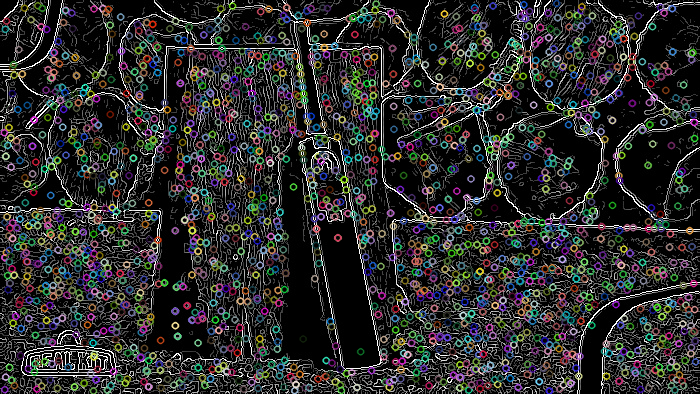

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
img = cv2.imread("/content/drive/MyDrive/images/canny_edge_train/bat_57.jpg")
sift = cv2.xfeatures2d.SIFT_create()
# surf = cv2.xfeatures2d.SURF_create()
orb = cv2.ORB_create(nfeatures=1500)
keypoints_sift, descriptors = sift.detectAndCompute(img, None)
# keypoints_surf, descriptors = surf.detectAndCompute(img, None)
keypoints_orb, descriptors = orb.detectAndCompute(img, None)
keypoints,descriptors= sift.detectAndCompute(img,None)
img_m=cv2.drawKeypoints(img,keypoints_sift,None)
# cv2.imshow("original image ",img)
cv2_imshow(img_m)
cv2.waitKey(0)
cv2.destroyAllWindows()

# sift=cv2.xfeatures2d.SIFT_create()


In [ ]:
import cv2
import matplotlib.pyplot as plt

# img = cv2.imread('/content/drive/MyDrive/images/apple_1.jpg',0)
# hist1 = cv2.calcHist([img],[0],None,[256],[0,256])
# img_2 = cv2.equalizeHist(img)
# hist2 = cv2.calcHist([img_2],[0],None,[256],[0,256])
# plt.subplot(221),plt.imshow(img);
# plt.subplot(222),plt.plot(hist1);
# plt.subplot(223),plt.imshow(img_2);
# plt.subplot(224),plt.plot(hist2);

# import Opencv
import cv2
import glob
import os
  
# import Numpy
import numpy as np
from google.colab.patches import cv2_imshow
path=glob.glob('/content/drive/MyDrive/images/canny_edge_test/*')
for i in path:
  img = cv2.imread(i,1)
  head_tail = os.path.split(i)
  sift = cv2.xfeatures2d.SIFT_create()
  # surf = cv2.xfeatures2d.SURF_create()
  orb = cv2.ORB_create(nfeatures=1500)
  keypoints_sift, descriptors = sift.detectAndCompute(img, None)
  # keypoints_surf, descriptors = surf.detectAndCompute(img, None)
  keypoints_orb, descriptors = orb.detectAndCompute(img, None)
  keypoints,descriptors= sift.detectAndCompute(img,None)
  img_m=cv2.drawKeypoints(img,keypoints_sift,None)
  # for i in range(3):
  #   plt.subplot(1,3,i+1)
  #   plt.imshow(output[i])
  #   plt.title(titles[i])
  #   plt.xticks([])
  #   plt.yticks([])
  cv2.imwrite('/content/drive/MyDrive/images/canny_sift_test/'+head_tail[1],img_m)
  

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

image = cv2.imread("/content/drive/MyDrive/images/pca_extraction_train/apple_1.jpg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#Create SIFT Feature Detector object
# Create FAST Detector object
fast = cv2.FastFeatureDetector()

# Obtain Key points, by default non max suppression is On
# to turn off set fast.setBool('nonmaxSuppression', False)
keypoints = fast.detect(gray, None)
print("Number of keypoints Detected: ", len(keypoints))

# Draw rich keypoints on input image
image = cv2.drawKeypoints(image, keypoints, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

cv2_imshow(image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Load the image
image1 = cv2.imread("/content/drive/MyDrive/images/pca_extraction_train/bottle_1.jpg")

# Convert image to RGB
image = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)

# Convert image to gray scale
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Display image and gray image
fx, plots = plt.subplots(1, 2, figsize=(20,10))

plots[0].set_title("Orignal Image")
plots[0].imshow(image)

plots[1].set_title("Gray Image")
plots[1].imshow(gray, cmap="gray")

Number of Keypoints Detected In The Image With Non Max Suppression:  137012
Number of Keypoints Detected In The Image Without Non Max Suppression:  574721


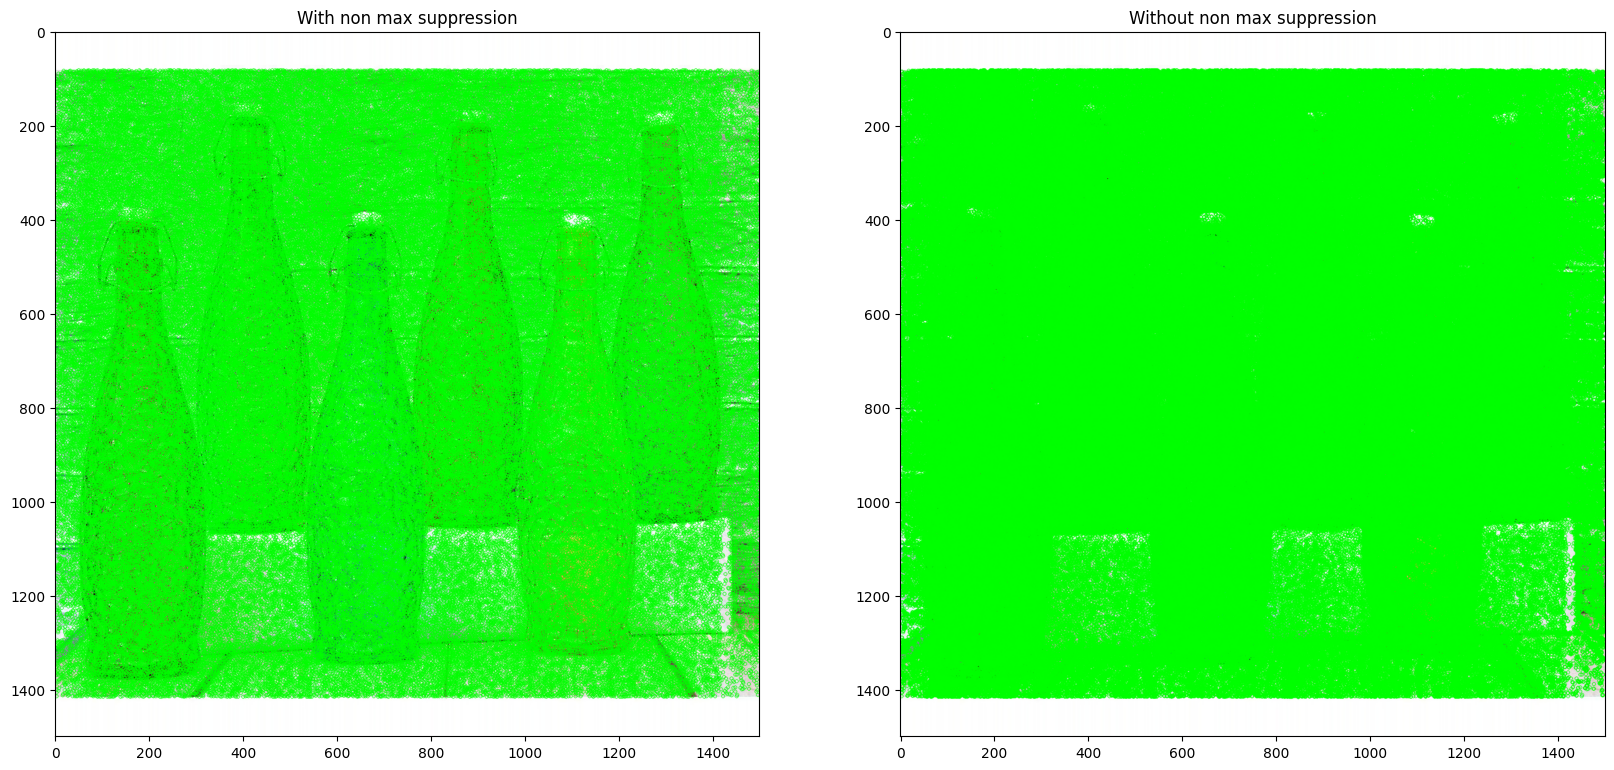

In [ ]:
fast = cv2.FastFeatureDetector_create() 

# Detect keypoints with non max suppression
keypoints_with_nonmax = fast.detect(gray, None)

# Disable nonmaxSuppression 
fast.setNonmaxSuppression(False)

# Detect keypoints without non max suppression
keypoints_without_nonmax = fast.detect(gray, None)

image_with_nonmax = np.copy(image)
image_without_nonmax = np.copy(image)

# Draw keypoints on top of the input image
cv2.drawKeypoints(image, keypoints_with_nonmax, image_with_nonmax, color=(0,255,0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv2.drawKeypoints(image, keypoints_without_nonmax, image_without_nonmax, color=(0,255,0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Display image with and without non max suppression
fx, plots = plt.subplots(1, 2, figsize=(20,10))

plots[0].set_title("With non max suppression")
plots[0].imshow(image_with_nonmax)

plots[1].set_title("Without non max suppression")
plots[1].imshow(image_without_nonmax)

# Print the number of keypoints detected in the training image
print("Number of Keypoints Detected In The Image With Non Max Suppression: ", len(keypoints_with_nonmax))

# Print the number of keypoints detected in the query image
print("Number of Keypoints Detected In The Image Without Non Max Suppression: ", len(keypoints_without_nonmax))